In [1]:
import os
import json
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # "0, 1" for multiple

import tensorflow as tf

In [3]:
INPUT_SHAPE = (512,256,3)
CLASS_NUMS = 4

In [4]:
def imread(path):
    im = cv2.imread(path)
    if im is None:
        return None
    
    im = im/255
    
    im_pad = np.zeros(INPUT_SHAPE,dtype=np.float64)
    h,w = im.shape[:2]
    if h/w > INPUT_SHAPE[0]/INPUT_SHAPE[1]:
        re_h = INPUT_SHAPE[0]
        re_w = int(w * (re_h / h))
    else:
        re_w = INPUT_SHAPE[1]
        re_h = int(h * (re_w / w))
    re_im = cv2.resize(im,(re_w,re_h))
    im_pad[:re_h,:re_w,:] = re_im.copy()
    return im_pad

In [5]:
def build_model(architecture='res50'):
    if architecture == 'res50':
        resnet_model = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                weights='imagenet',input_shape=INPUT_SHAPE,pooling='avg')
        resnet_output = resnet_model.output

        resnet_input = resnet_model.input
#     elif architecture == 'res101':
#         resnet_input = tf.keras.Input((None,None,3))
#         _,_,_,_,C5 = resnet_graph(resnet_input,"resnet101")
#         resnet_output = tf.keras.layers.GlobalAveragePooling2D()(C5)

    output = tf.keras.layers.Dense(CLASS_NUMS,activation='softmax',name='fc_softmax')(resnet_output)

    sm_model = tf.keras.models.Model(inputs = resnet_input,outputs = output, name = 'res50_softmax')
    
    return sm_model

In [11]:
im_dir = '../dataset/bodytype/image_women/'
dataversion = 'v2'
train_json = '../dataset/bodytype/women_'+dataversion+'_train.json'
val_json = '../dataset/bodytype/women_'+dataversion+'_val.json'

In [12]:
if dataversion == 'v1':
    class_ids_dict = {0:u"Thin",1:u"Nomal",2:u"Fat",3:u"Fater"}
    model_path = './old_logs/20180801T1101_res50_momentum/ep_0094.h5'
if dataversion == 'v2':
    class_ids_dict = {0:u"yHourglass",1:u"yPear",2:u"yApple",3:u"yBanana"}
    model_path = './old_logs/20180902T1520_res50_adam_v2/ep_0020.h5'

In [13]:
f = open(train_json,'r')
train_infos = json.load(f)
f.close()
f = open(val_json,'r')
val_infos = json.load(f)
f.close()

In [14]:
architecture = 'res50'
model = build_model(architecture=architecture)
if model_path is not None:
    model.load_weights(model_path,by_name=True)

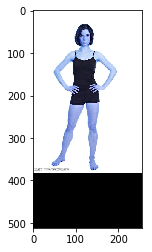

0 yHourglass
yHourglass 0.315711
yPear 0.3089312
yApple 0.17663372
yBanana 0.19872408


In [31]:
im = imread('../dataset/bodytype/test_im/4.jpg')
plt.imshow(im)
plt.show()
im = np.array([im])
res = model.predict(im)
ress = np.argmax(res)
print(ress,class_ids_dict[ress])
for i,con in enumerate(res[0]):
    print(class_ids_dict[i],con)

In [12]:
tr = 0
fa = 0
cur_infos = val_infos
for name in cur_infos.keys():
    im = imread(os.path.join(im_dir,name))
    if im is None:
        continue
    im = np.array([im])
    res = model.predict(im)
    res = np.argmax(res)
    if res == cur_infos[name]['label']:
        tr += 1
    else:
        fa += 1
print(tr,fa,tr/(fa+tr))

KeyboardInterrupt: 